# SHAP for Linear Models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error 

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'
file_name = 'wine.csv'

In [3]:
# Chech if the file exists in the current directory
try:
    wine = pd.read_csv(file_name)
except FileNotFoundError:
    print(f'Downloading {file_name} from {url}')
    wine = pd.read_csv(url, sep=";")
    wine.to_csv(file_name, index=False)
    print('Download complete!')

## EDA

In [4]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [5]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [6]:
wine.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
fixed acidity,4898.0,6.85,0.84,3.80,6.30,6.80,7.30,14.20
volatile acidity,4898.0,0.28,0.10,0.08,0.21,0.26,0.32,1.10
citric acid,4898.0,0.33,0.12,0.00,0.27,0.32,0.39,1.66
residual sugar,4898.0,6.39,5.07,0.60,1.70,5.20,9.90,65.80
chlorides,4898.0,0.05,0.02,0.01,0.04,0.04,0.05,0.35
free sulfur dioxide,4898.0,35.31,17.01,2.00,23.00,34.00,46.00,289.00
total sulfur dioxide,4898.0,138.36,42.50,9.00,108.00,134.00,167.00,440.00
density,4898.0,0.99,0.00,0.99,0.99,0.99,1.00,1.04
pH,4898.0,3.19,0.15,2.72,3.09,3.18,3.28,3.82
sulphates,4898.0,0.49,0.11,0.22,0.41,0.47,0.55,1.08


In [7]:
wine.corr().round(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000,-0.023,0.289,0.089,0.023,-0.049,0.091,0.265,-0.426,-0.017,-0.121,-0.114
volatile acidity,-0.023,1.000,-0.149,0.064,0.071,-0.097,0.089,0.027,-0.032,-0.036,0.068,-0.195
citric acid,0.289,-0.149,1.000,0.094,0.114,0.094,0.121,0.150,-0.164,0.062,-0.076,-0.009
residual sugar,0.089,0.064,0.094,1.000,0.089,0.299,0.401,0.839,-0.194,-0.027,-0.451,-0.098
chlorides,0.023,0.071,0.114,0.089,1.000,0.101,0.199,0.257,-0.090,0.017,-0.360,-0.210
free sulfur dioxide,-0.049,-0.097,0.094,0.299,0.101,1.000,0.616,0.294,-0.001,0.059,-0.250,0.008
total sulfur dioxide,0.091,0.089,0.121,0.401,0.199,0.616,1.000,0.530,0.002,0.135,-0.449,-0.175
density,0.265,0.027,0.150,0.839,0.257,0.294,0.530,1.000,-0.094,0.074,-0.780,-0.307
pH,-0.426,-0.032,-0.164,-0.194,-0.090,-0.001,0.002,-0.094,1.000,0.156,0.121,0.099
sulphates,-0.017,-0.036,0.062,-0.027,0.017,0.059,0.135,0.074,0.156,1.000,-0.017,0.054


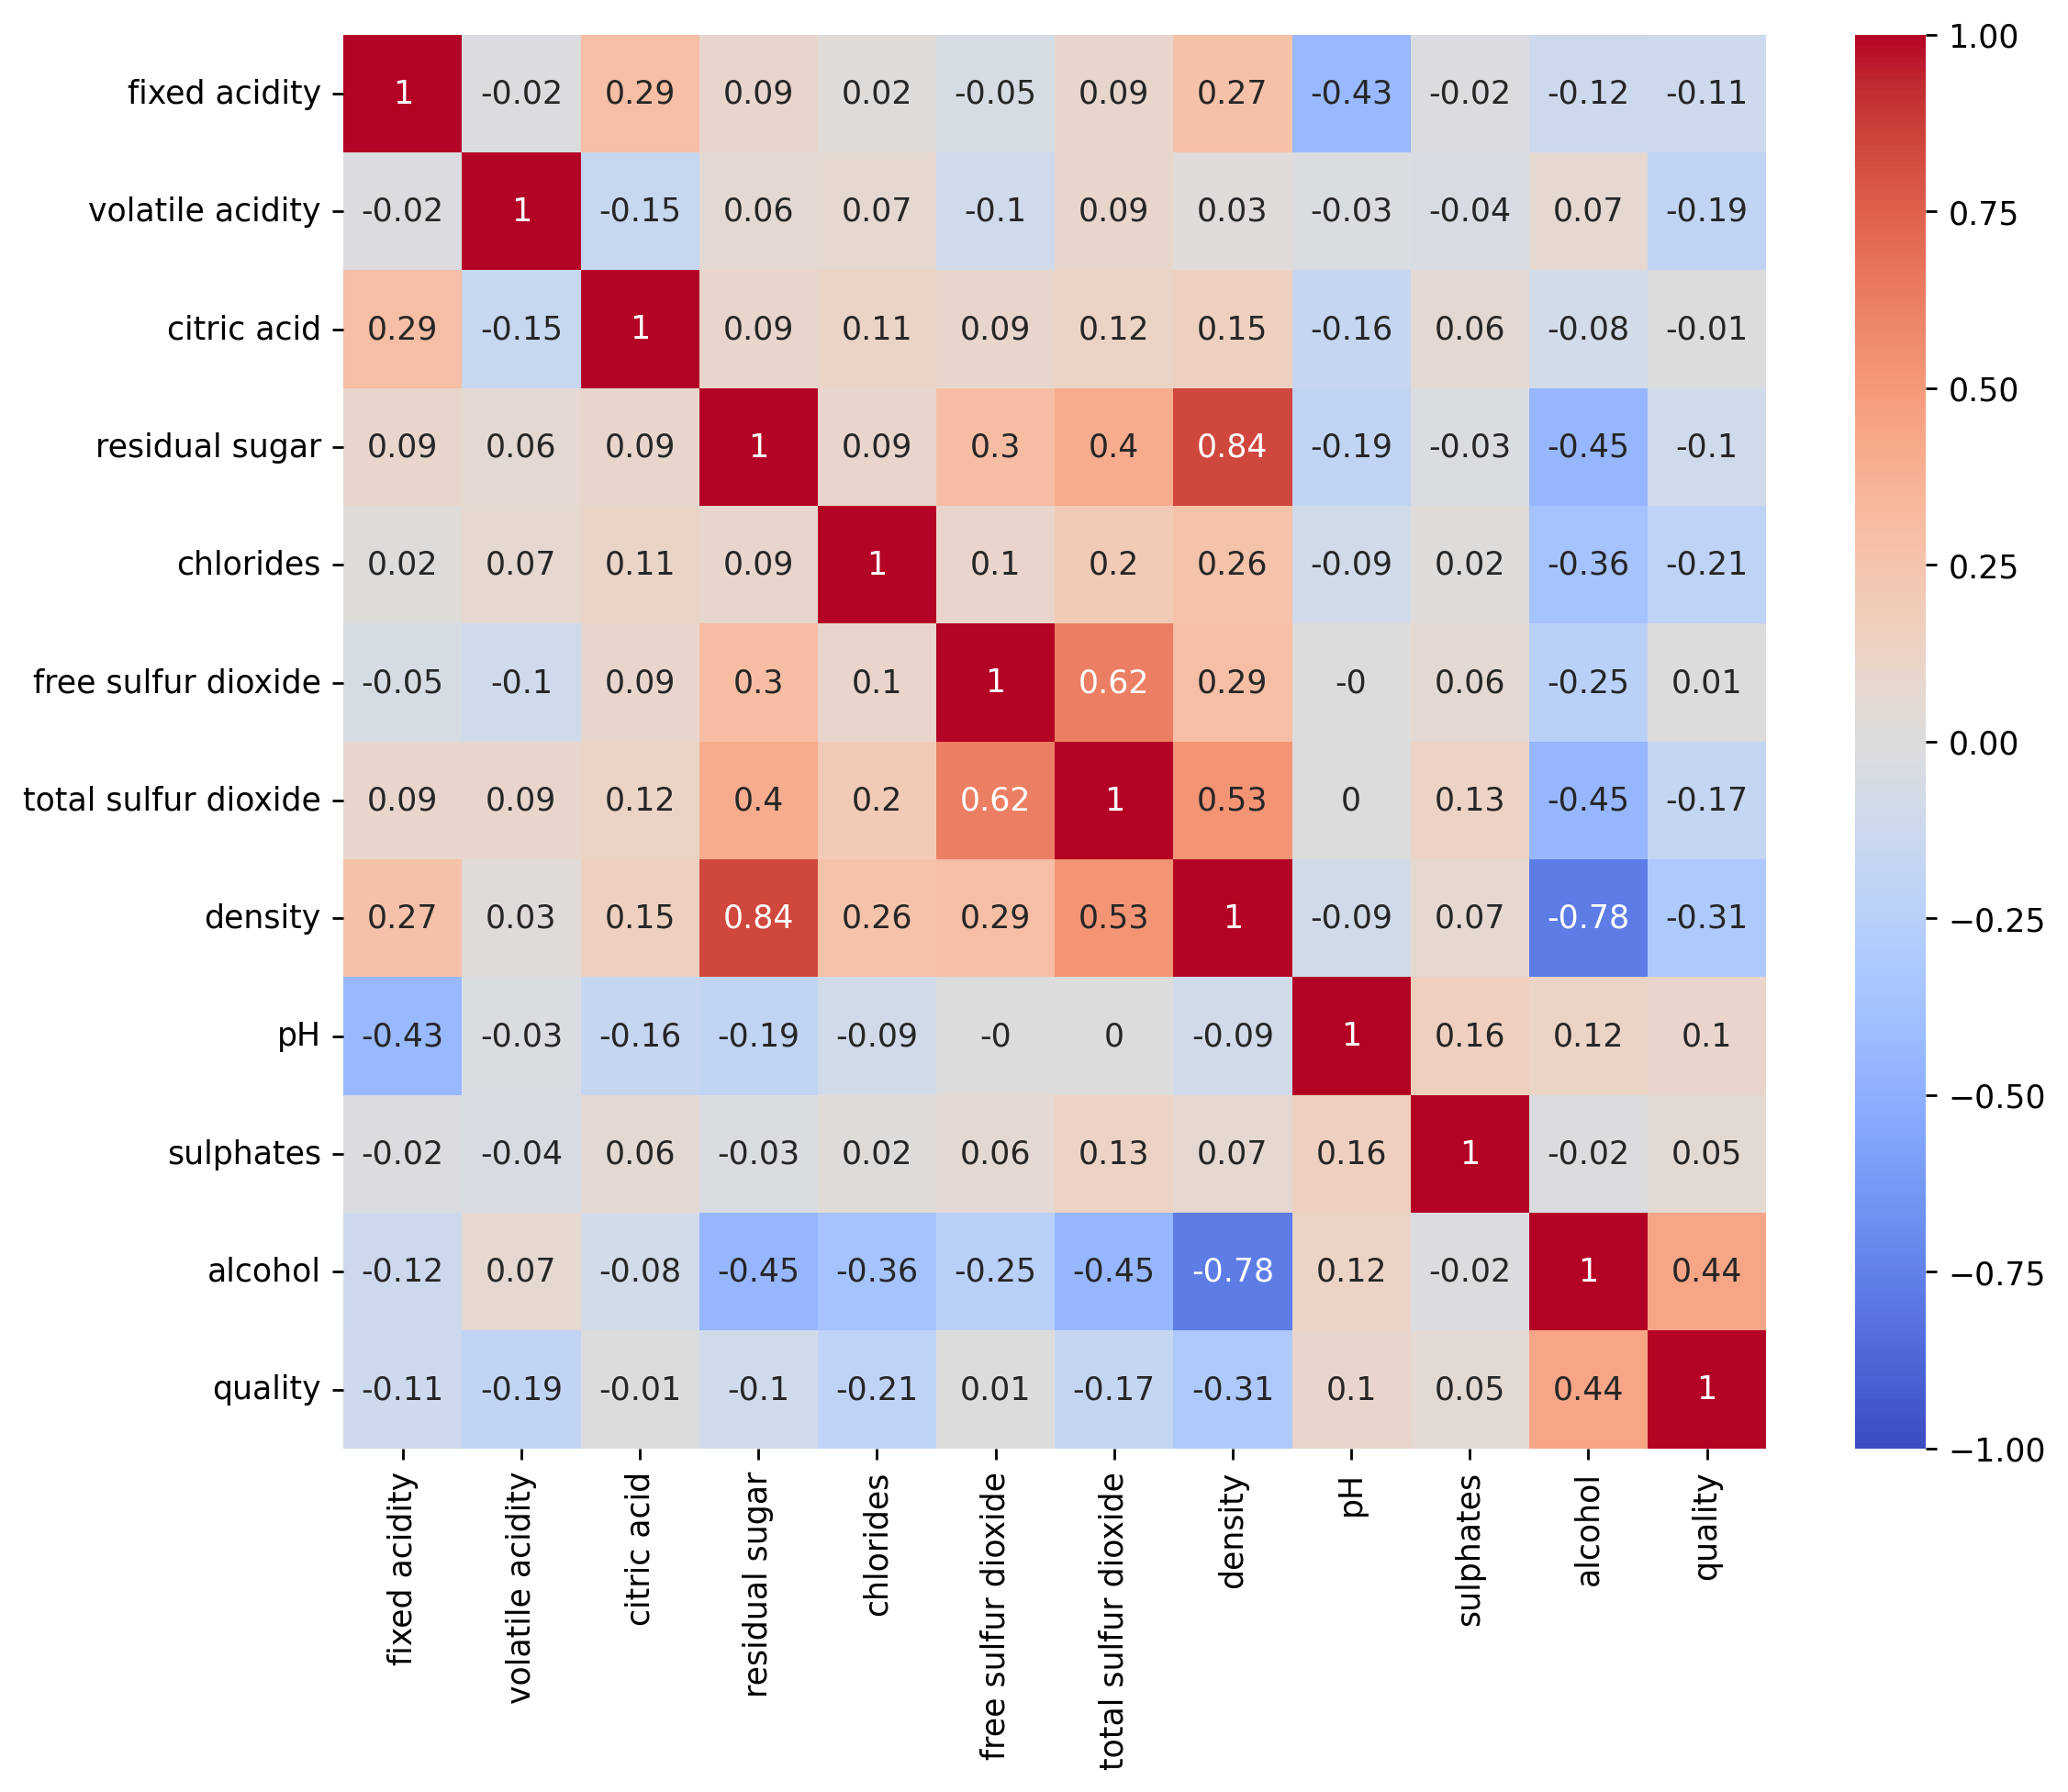

In [8]:
plt.figure(figsize=(10,8), dpi=250)
sns.heatmap(data=wine.corr().round(2), cmap="coolwarm", vmin=-1, vmax=1, annot=True);

## Fit a Linear Regression Model

In [9]:
# Create X and Y sets and Train Test Split
y = wine['quality']
X = wine.drop('quality', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## Evaluate the Linear Regression Model

In [11]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = model.score(X_test, y_test)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R Squared: {r2:.2f}")

MAE: 0.59
MSE: 0.57
RMSE: 0.75
R Squared: 0.27


### Interpreting the Coefficients

In [12]:
coefs = pd.DataFrame({
    'feature': X.columns.values,
    'coefficicents': np.round(model.coef_,3)
})

print(coefs.to_markdown(index=False))

| feature              |   coefficicents |
|:---------------------|----------------:|
| fixed acidity        |           0.046 |
| volatile acidity     |          -1.915 |
| citric acid          |          -0.061 |
| residual sugar       |           0.071 |
| chlorides            |          -0.026 |
| free sulfur dioxide  |           0.005 |
| total sulfur dioxide |          -0     |
| density              |        -124.264 |
| pH                   |           0.601 |
| sulphates            |           0.649 |
| alcohol              |           0.229 |


## SHAP Values

In [13]:
explainer = shap.LinearExplainer(model, X_train)

In [14]:
shap_values = explainer(X_test)
print(shap_values.values)

[[-0.03479769  0.00306381 -0.00545601 ... -0.06541621  0.05289943
   0.08545841]
 [-0.06234203 -0.45650842  0.00986986 ...  0.00066077  0.01395506
   0.59691113]
 [ 0.01570028  0.07965919 -0.00422994 ...  0.04871676 -0.05095221
   0.36790245]
 ...
 [-0.03938841  0.06051034  0.00680469 ...  0.04871676 -0.05095221
  -0.250421  ]
 [ 0.03406317  0.00306381  0.00067434 ... -0.07142321  0.02044579
  -0.29622273]
 [-0.00266262  0.13710572 -0.00422994 ...  0.18087073 -0.0249893
  -0.13591665]]


### Interpreting SHAP Values - Local Values

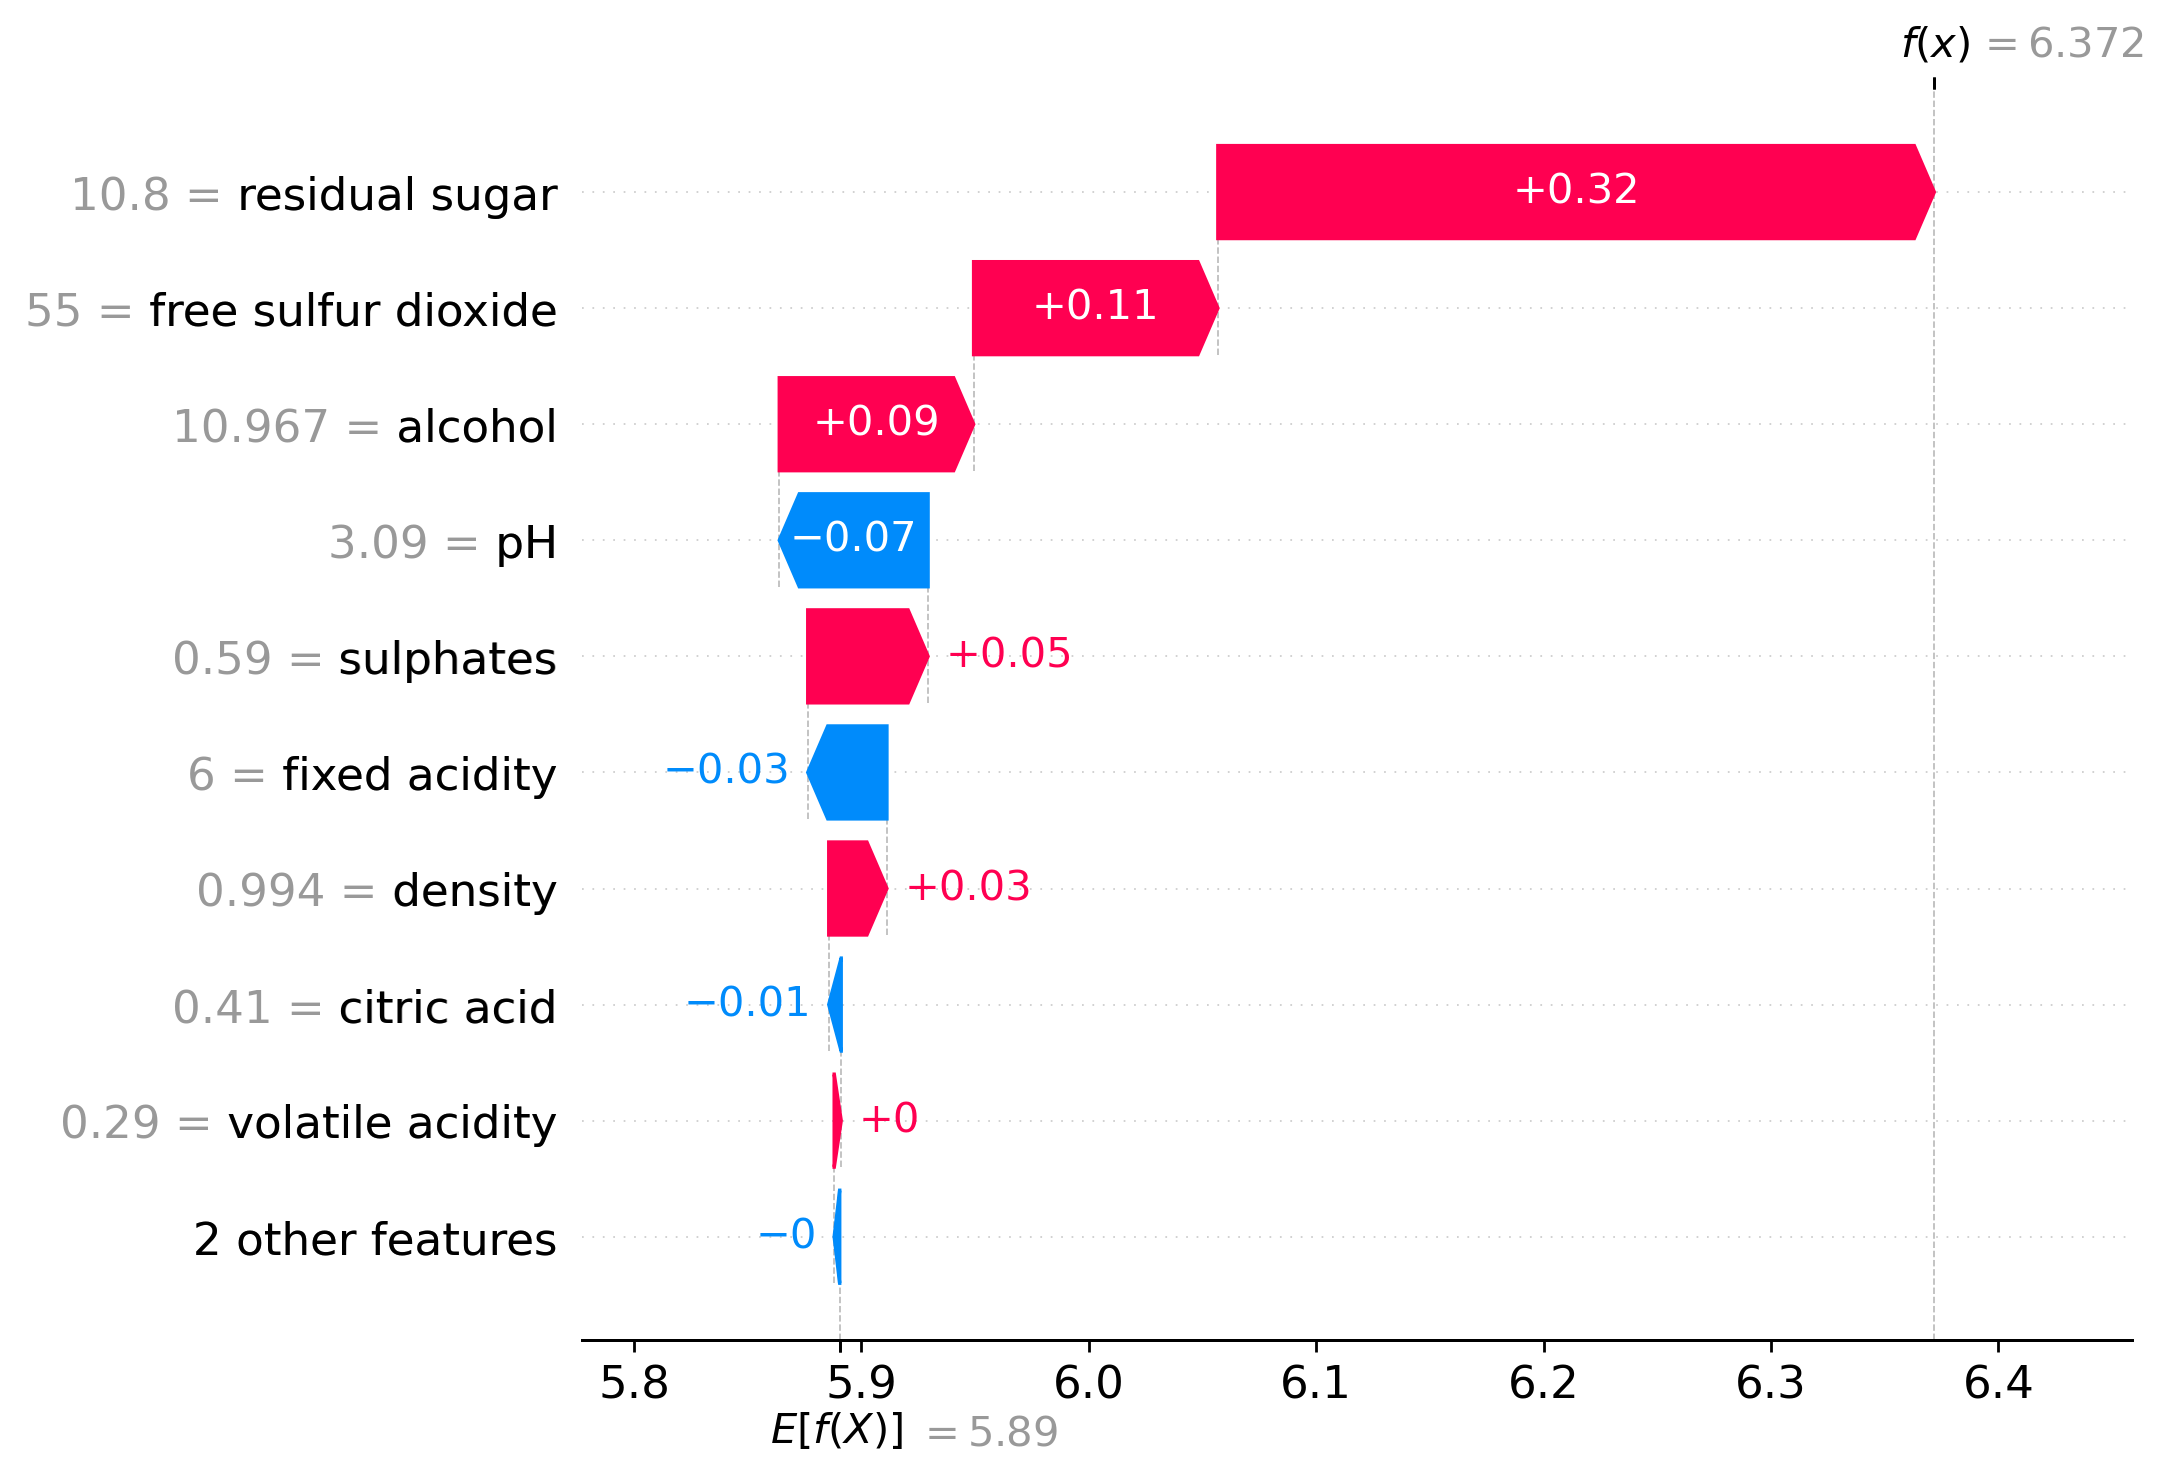

In [15]:
plt.figure(figsize=(10,8), dpi=250)
shap.plots.waterfall(shap_values[0])

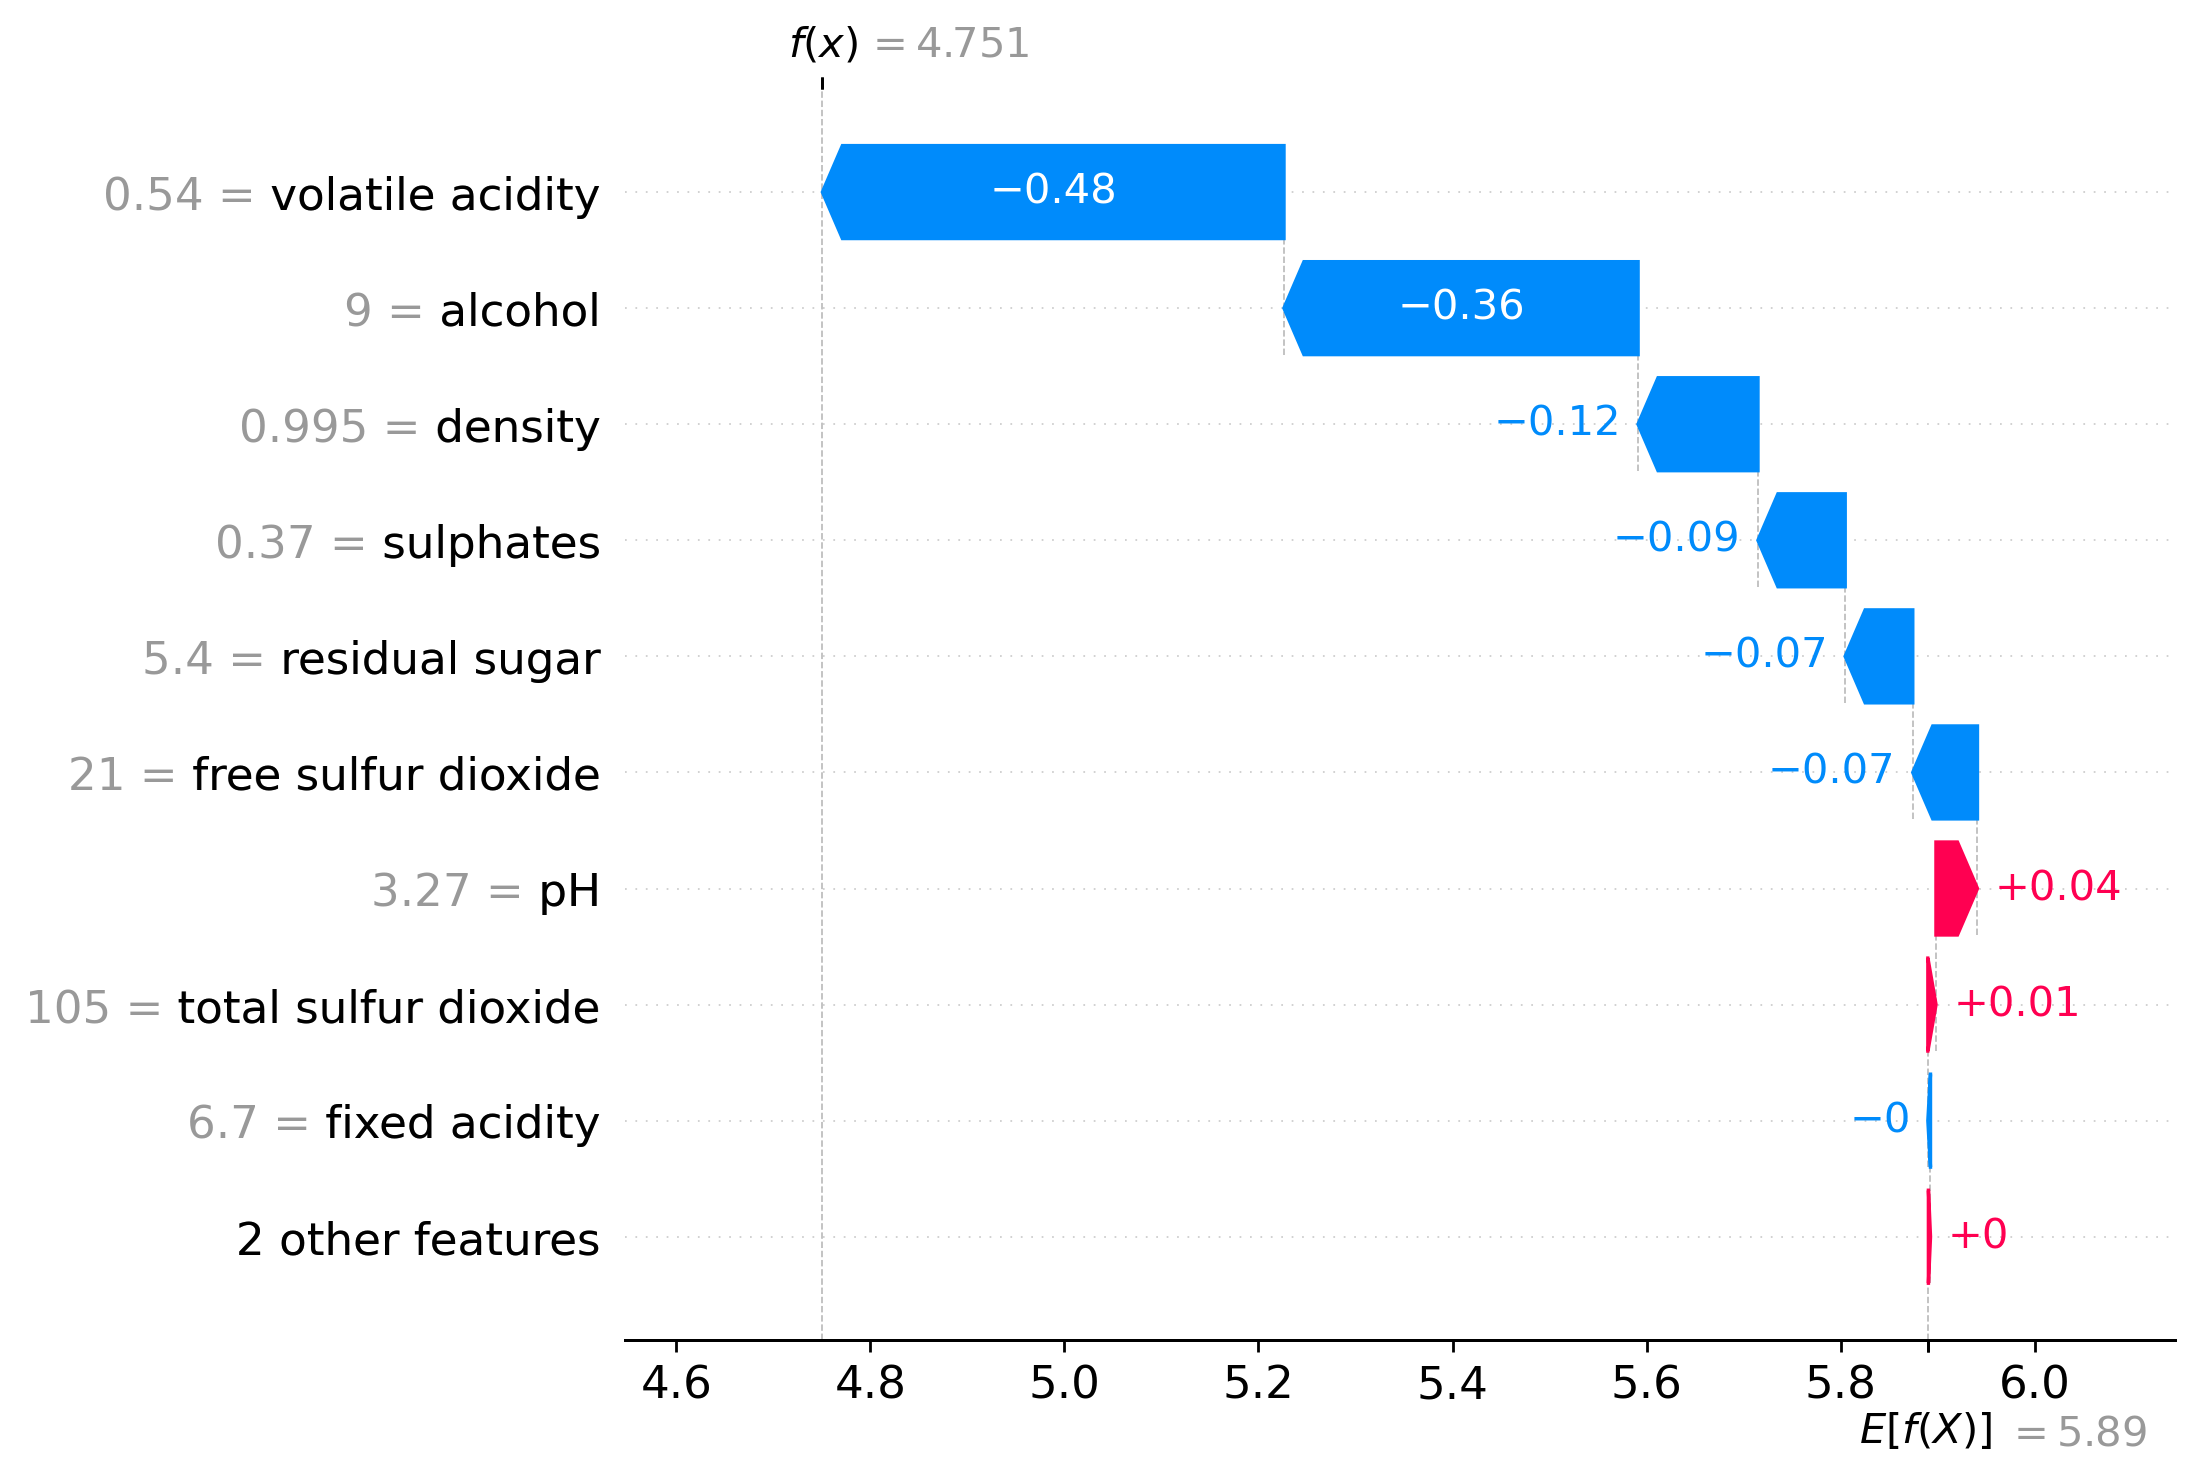

In [16]:
plt.figure(figsize=(10,8), dpi=250)
shap.plots.waterfall(shap_values[11])

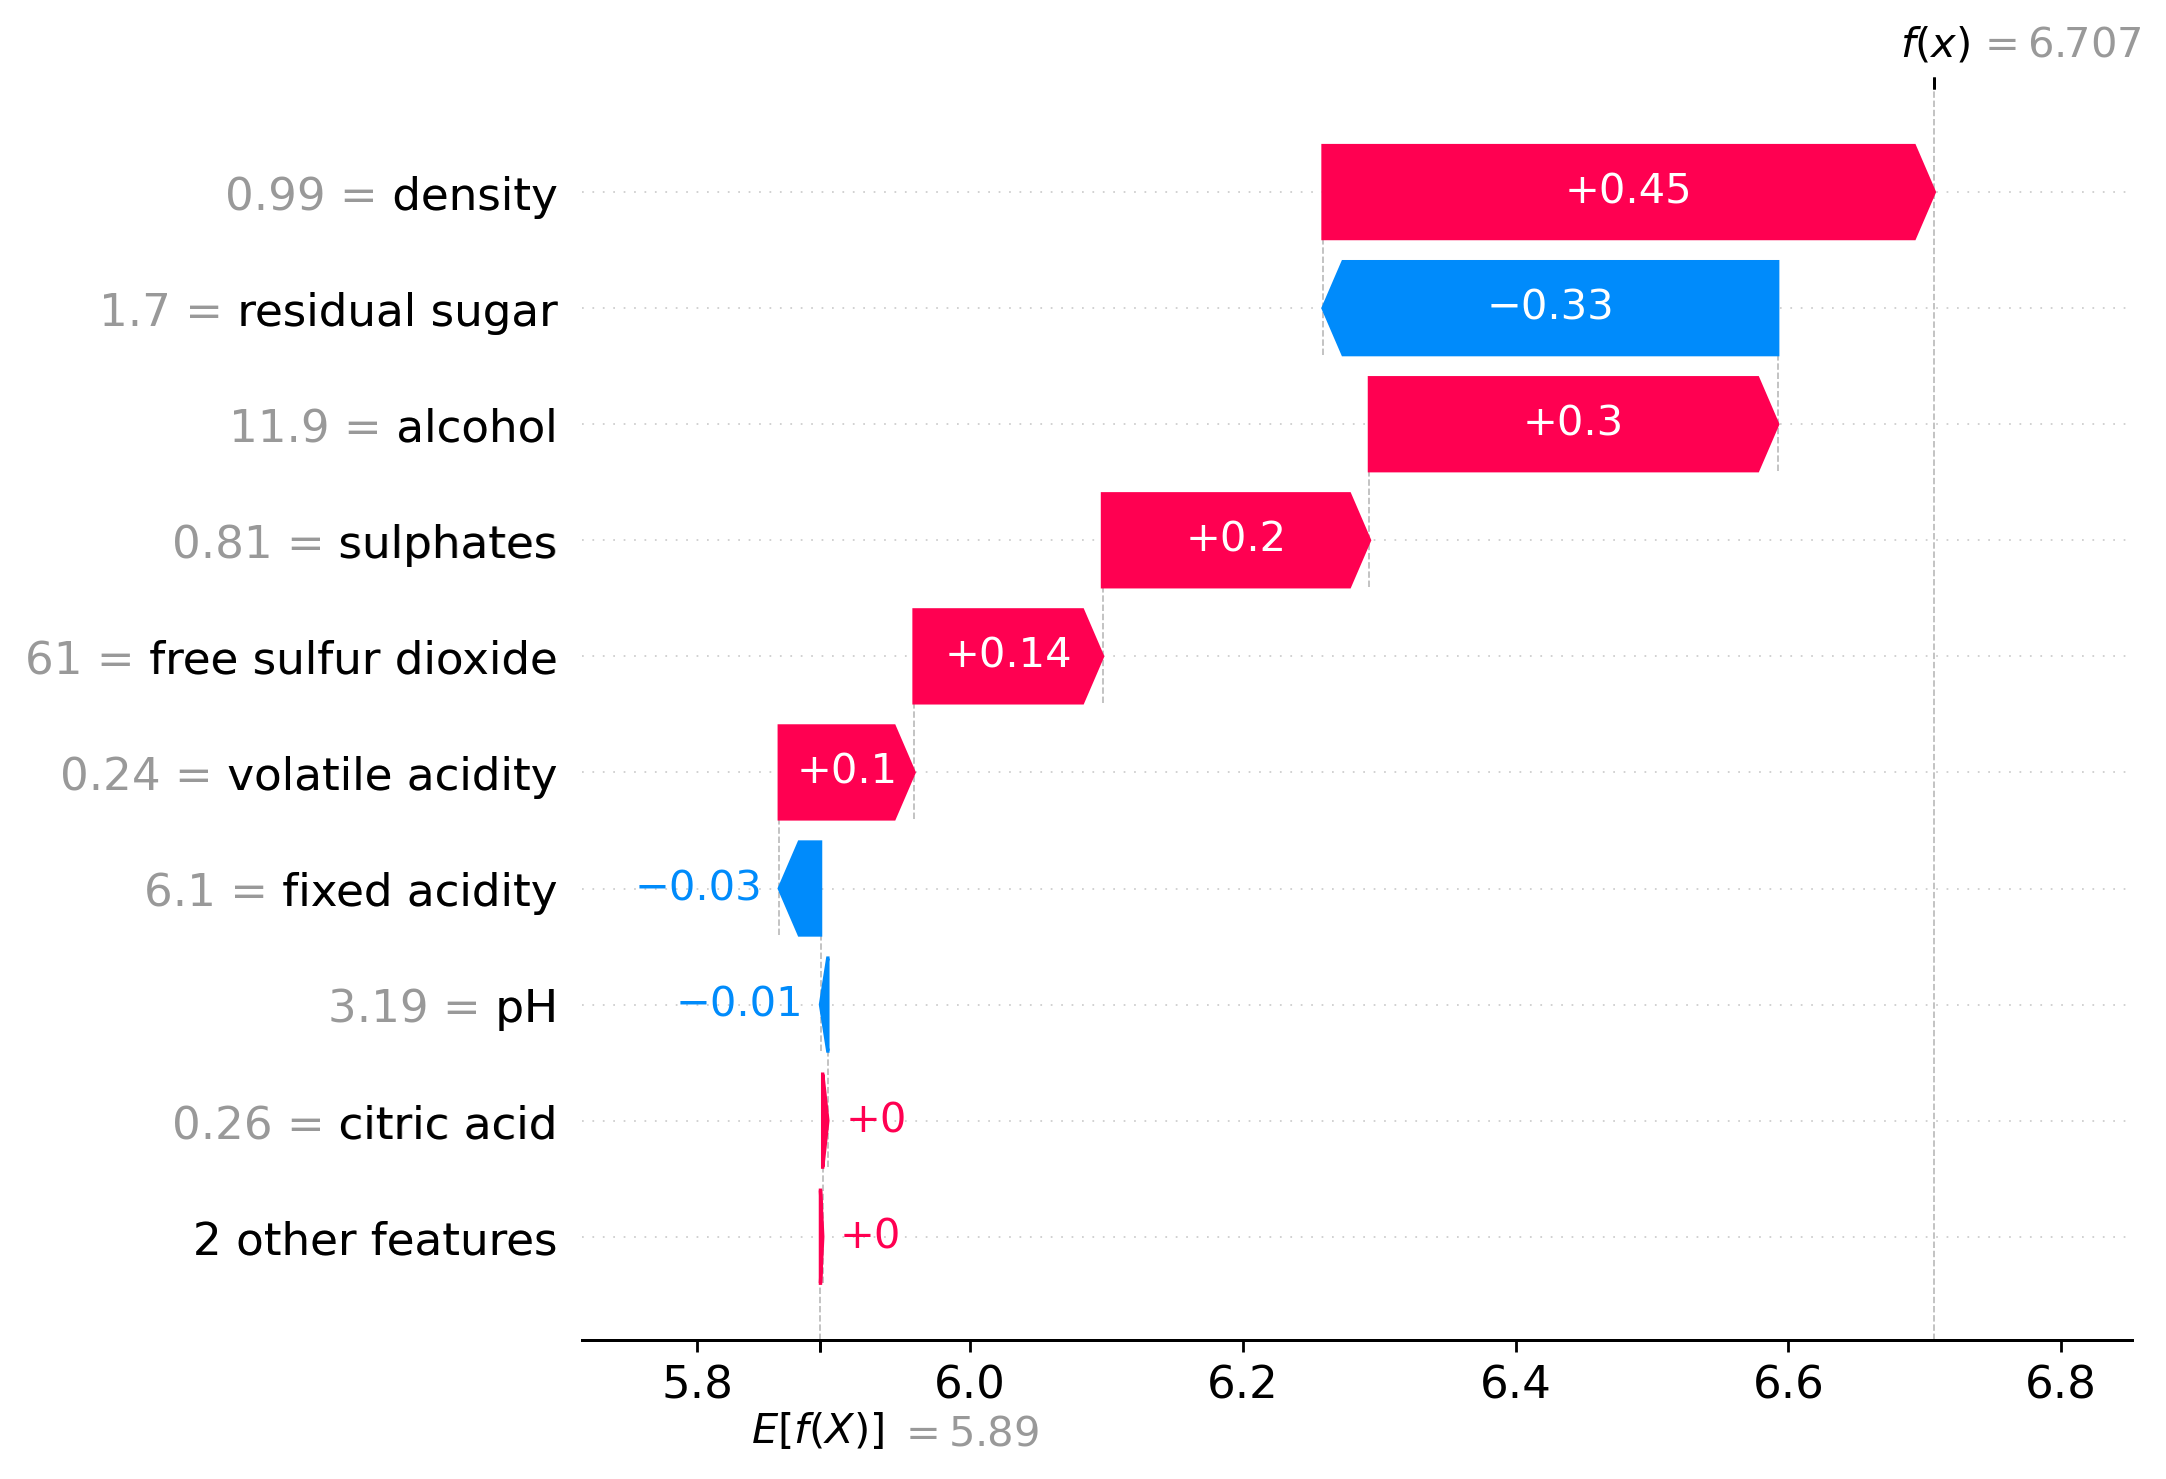

In [17]:
plt.figure(figsize=(10,8), dpi=250)
shap.plots.waterfall(shap_values[63])

### Interpreting SHAP Values - Global Values

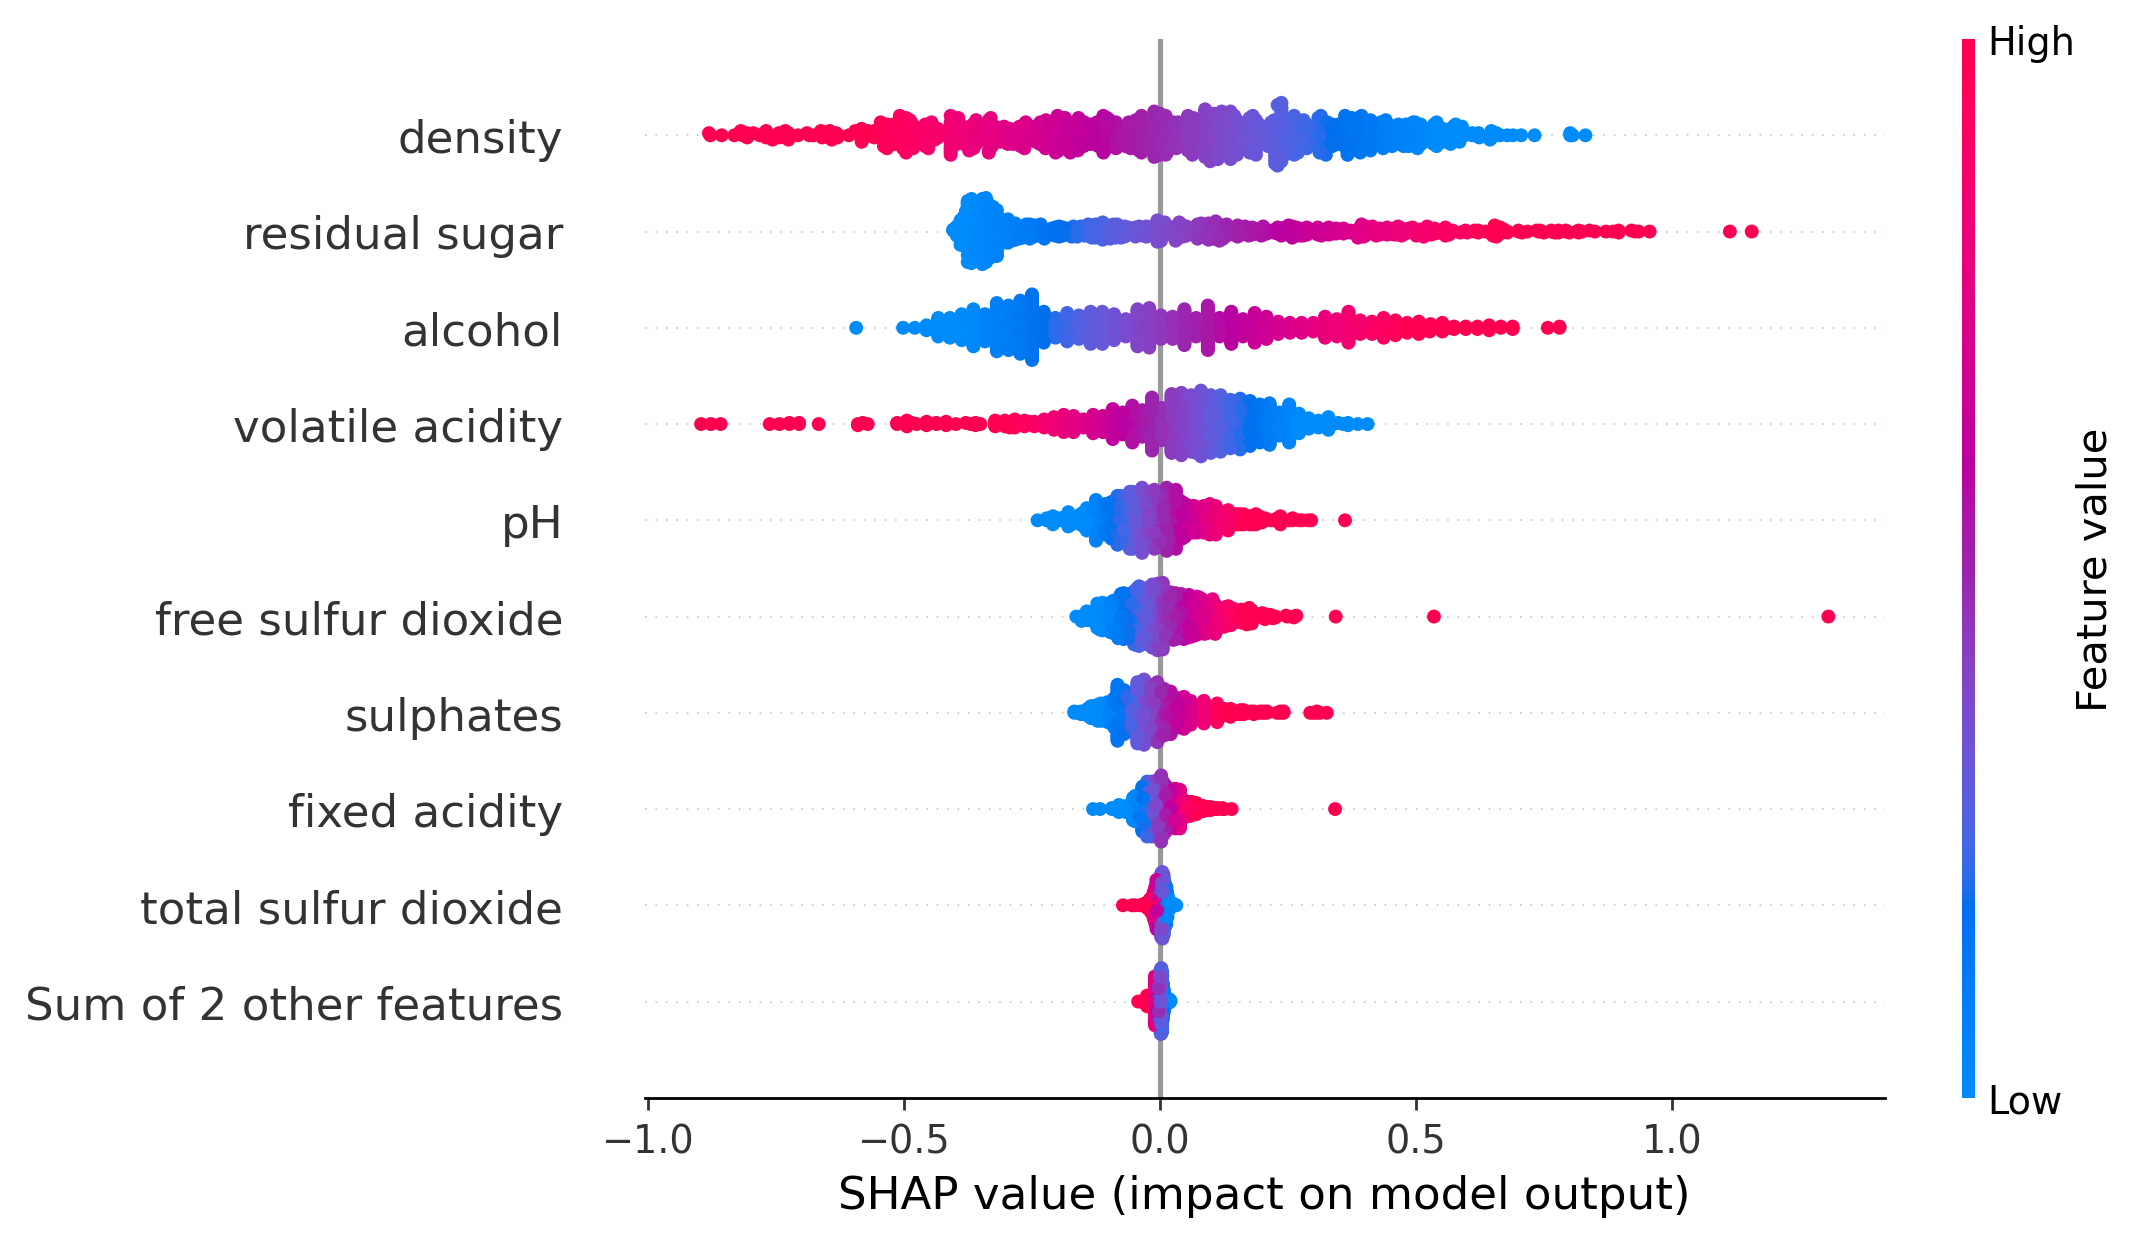

In [18]:
plt.figure(figsize=(10,8), dpi=250)
shap.plots.beeswarm(shap_values)